# Survival SHAREs - Demo 

This notebook demonstrates fitting and evaluating single-outcome survival SHARES. We use the Metabric dataset.

## 0. Setup

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch

import seaborn as sns
sns.set_style("whitegrid")

import wandb 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from survshares.datasets import Rossi, Metabric, GBSG2

# Prepare dataset
dataset = Metabric()
dataset.load(normalise=False)
X_train, X_test, T_train, T_test, E_train, E_test = dataset.split()

## 1. Proportional Hazards

We fit a PH survival SHARE with negative partial log-likelihood + shrink penalty as the fitness function, and approximate negative partial log-likelihood (cumulative sum approximation) as the shape model's loss. 

The fitting below only demonstrates with 2 generations of 2 programs each. Then, we inspect the results of a full training run (which is done via a separate script).

### 1.1 Local Demo

We initialise the fitness and loss and fit 2 generations of 2 programs each, just to verify everything works. This includes WandB logging which is currently commented out.


In [3]:
from survshares.metrics import negative_pll 
from gplearn.gplearn.fitness import make_fitness

def fitness_npll_shrink(y_true, y_pred, sample_weight):
    """
    Partial log-likelihood with shrink penalty for gplearn. Smaller is better.
    """
    pll = negative_pll(y_true, y_pred, sample_weight)
    result = pll + 0.05 * np.abs(y_pred).mean()
    if np.isinf(result):
        result = np.inf # Cover -inf with +inf
    return result


fitness_npll_shrink = make_fitness(
    function=fitness_npll_shrink, greater_is_better=False
)

In [ ]:
from gplearn.gplearn.model import ShapeNN
from survshares.symbolic_regressor import SurvSymbolicRegressor
from survshares.loss import approximateNpllLoss, npllLoss
from survshares.base_symbolic import BaseSurvSymbolic
from survshares.program import SurvProgram

# run = wandb.init(
#     project="shares_risk_study",
#     config={
#         "dataset": "metabric",
#         "fitness": "npll_shrink",
#         "epochs": 5,
#         "generations": 5,
#     }
# )
run = None

survival_params = {
    "program_class": SurvProgram,
    "population_size": 2,
    "generations": 2,
    "tournament_size": 10,
    "function_set": ("add", "mul", "div", "shape"),
    "logging_console": True,
    "logging_wandb": True,
    "wandb_run": run,
    "random_state": 42,
    "const_range": None,
    "n_jobs": 1,
    "p_crossover": 0.4,
    "p_subtree_mutation": 0.2,
    "p_point_mutation": 0.2,
    "p_hoist_mutation": 0.05,
    "p_point_replace": 0.2,
    "parsimony_coefficient": 0.0,
    "metric": fitness_npll_shrink,
    "parsimony_coefficient": 0.0,
    "optim_dict": {
        "alg": "adam",
        "lr": 1e-2,  # tuned automatically
        "max_n_epochs": 100,
        "tol": 1e-3,
        "task": "survival",
        "device": "cpu",
        "batch_size": 1000,
        "shape_class": ShapeNN,
        "constructor_dict": {
            "n_hidden_layers": 5,
            "width": 10,
            "activation_name": "ELU",
        },
        "num_workers_dataloader": 0,
        "seed": 42,
        "checkpoint_folder": Path("data/checkpoints/survshare_rossi"),
        "keep_models": True,
        "loss_fn": approximateNpllLoss(),
    },
}

model = SurvSymbolicRegressor(**survival_params, categorical_variables=dataset.categorical_values)

/home/paperspace/SurvSHAREs/survshares/base_symbolic.py:73: UserWarning: No wandb_run provided, setting 'logging_wandb' to False
  warnings.warn("No wandb_run provided, setting 'logging_wandb' to False")


In [ ]:
from experiments.utils import (
    load_share_from_checkpoint,
    get_n_shapes,
    get_n_variables,
)
from survshares.hazard_model import HazardModel
checkpoint_dir = Path("data/checkpoints/survshare_rossi")
def generation_callback(population, best_program): 
    best_program = best_program.fit(torch.Tensor(X_train), torch.Tensor(T_train), torch.Tensor(E_train), dataset.ohe_matrices(X_train))
    esr_wrap = HazardModel(
        best_program,
        categorical_variables=dataset.categorical_values,
    ).prepare_estimands(X_train, T_train, E_train) 
    scores = esr_wrap.score(X_test, T_test, E_test, extended=False)
    scores.update(dict(
        id=best_program.id,
        # length=best_program.length_,
        # raw_fitness_=best_program.raw_fitness_,
        n_shapes=get_n_shapes(str(best_program)),
        n_variables=get_n_variables(str(best_program)),
    ))
    wandb.log(scores)

In [ ]:
model.fit(torch.Tensor(X_train), torch.Tensor(T_train), torch.Tensor(E_train), generation_callback)

We plot the shape functions. This dataset only has binary categorical variables, so in practice we could represent those parameters more simply as multiplication coefficients rather than shape functions.

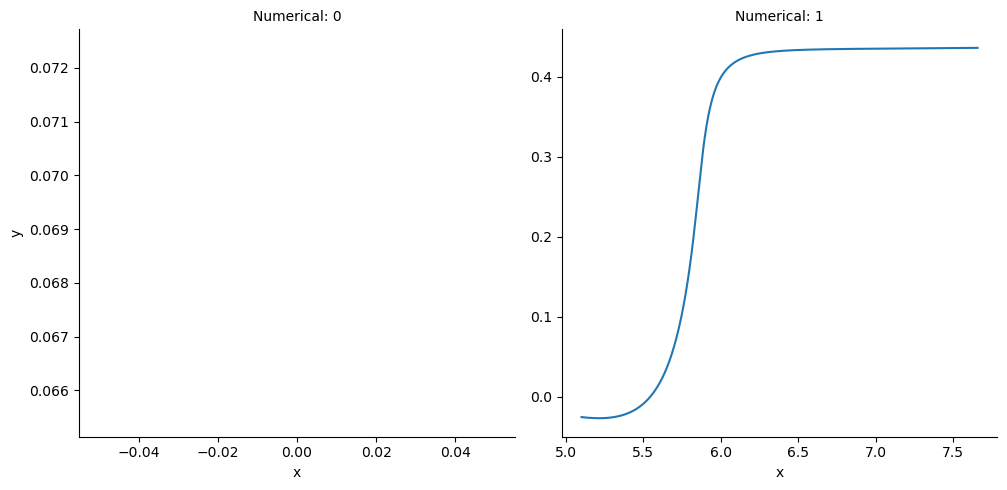

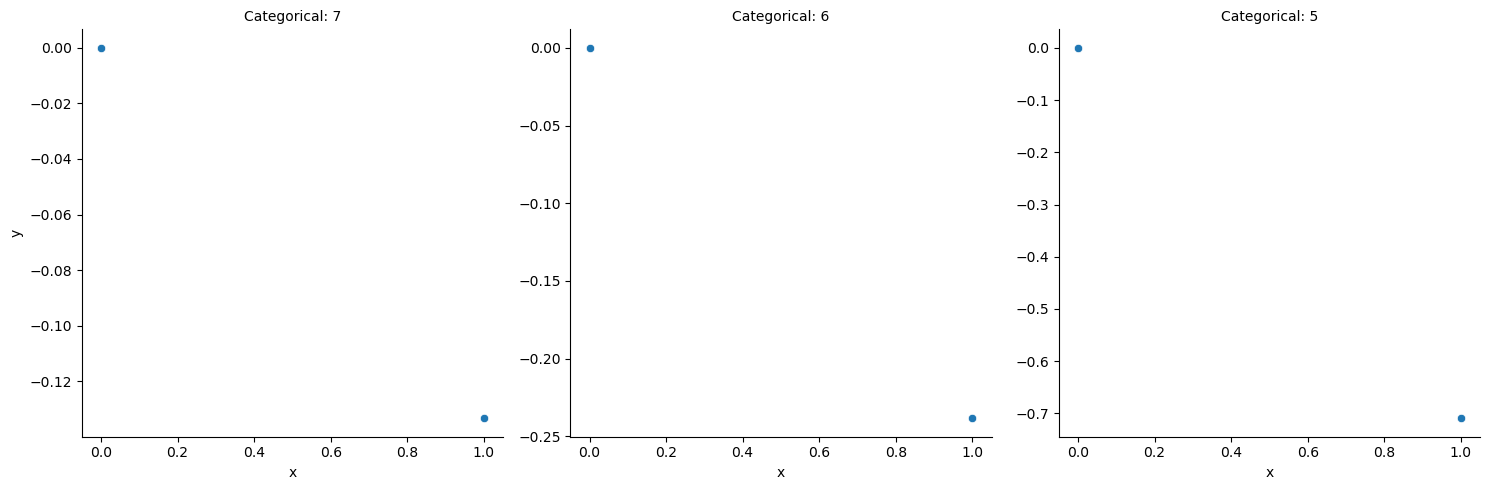

In [ ]:
model._program.plot_shape_functions(
    dataset.numerical_ranges,
    dataset.categorical_values
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

{'mean_absolute_difference_binned': np.float64(0.08630027654499448),
 'mean_absolute_difference_smoothed': np.float64(0.42269698379324966),
 'median_absolute_difference_binned': np.float64(0.06803096605880991),
 'median_absolute_difference_smoothed': np.float64(0.42711126581261416)}

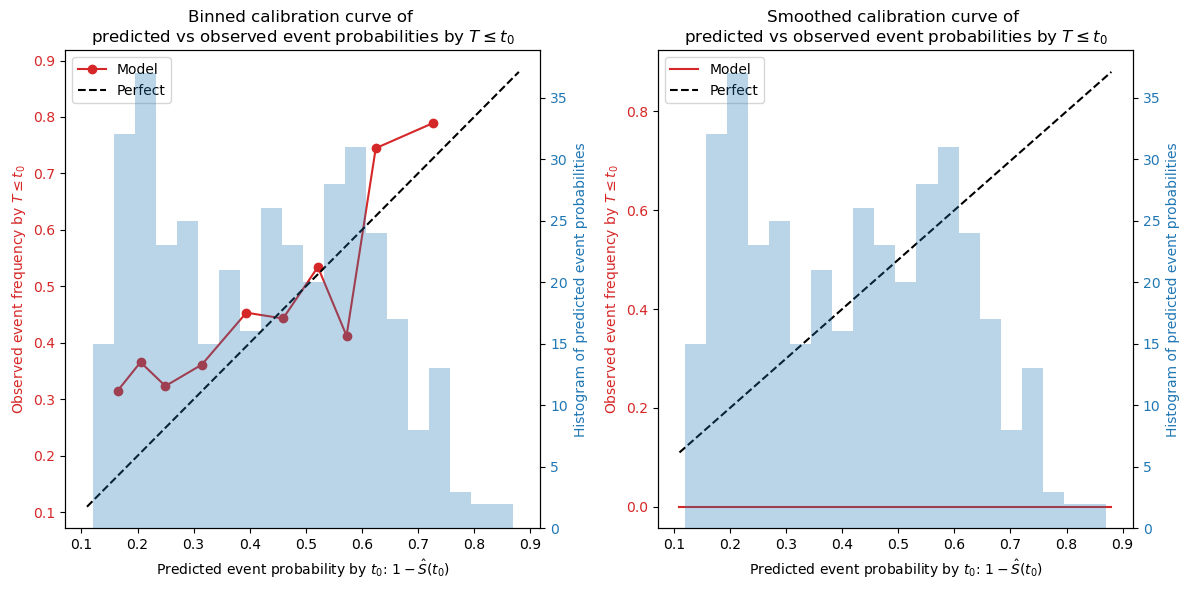

In [ ]:
from survshares.hazard_model import HazardModel 

hm = HazardModel(model, dataset.categorical_values).prepare_estimands(X_train, T_train, E_train)
hm.score(torch.Tensor(X_test), torch.Tensor(T_test), torch.Tensor(E_test))
hm.plot_calibration(torch.Tensor(X_test), torch.Tensor(T_test), torch.Tensor(E_test), t0=np.unique(T_train)[len(T_train)//2])

### 1.2. Benchmark Results

We run the full program evolution outside this notebook and load the results. We inspect the shape functions, scores, and calibration of the best model by validation set fitness.

In [56]:
timestamp = '2025-05-27T16.30.37'
checkpoint_dir = Path("data/checkpoints/metabric_npll_shrink_npll_approximate") 

results_df = pd.read_csv(checkpoint_dir / timestamp / "results.csv")
best_share = results_df.sort_values('raw_fitness').iloc[0]
best_share

id                                                                          346
equation                      add(shape(add(add(div(add(mul(shape(X3), shape...
raw_fitness                                                            6.894102
integrated_brier_score                                                 0.160062
concordance_index_censored                                             0.654545
concordance_index_ipcw                                                 0.643976
cumulative_dynamic_auc                                                      NaN
neg_partial_log_likelihood                                             5.098717
n_shapes                                                                      8
n_variables                                                                   7
Name: 222, dtype: object

In [57]:
from experiments.utils import load_share_from_checkpoint
best_model = load_share_from_checkpoint(
    timestamp,
    best_share.equation,
    checkpoint_dir=checkpoint_dir,
    task="survival",
    n_features=len(dataset.features),
    equation_id=best_share.id,
    loss_fn=approximateNpllLoss(),
    categorical_variables_dict=dataset.categorical_values,
    program_class=SurvProgram,
)


add(shape(add(add(div(add(mul(shape(X3), shape(X8)), shape(X2)), shape(X7)), shape(X4)), shape(X5))), shape(X6))


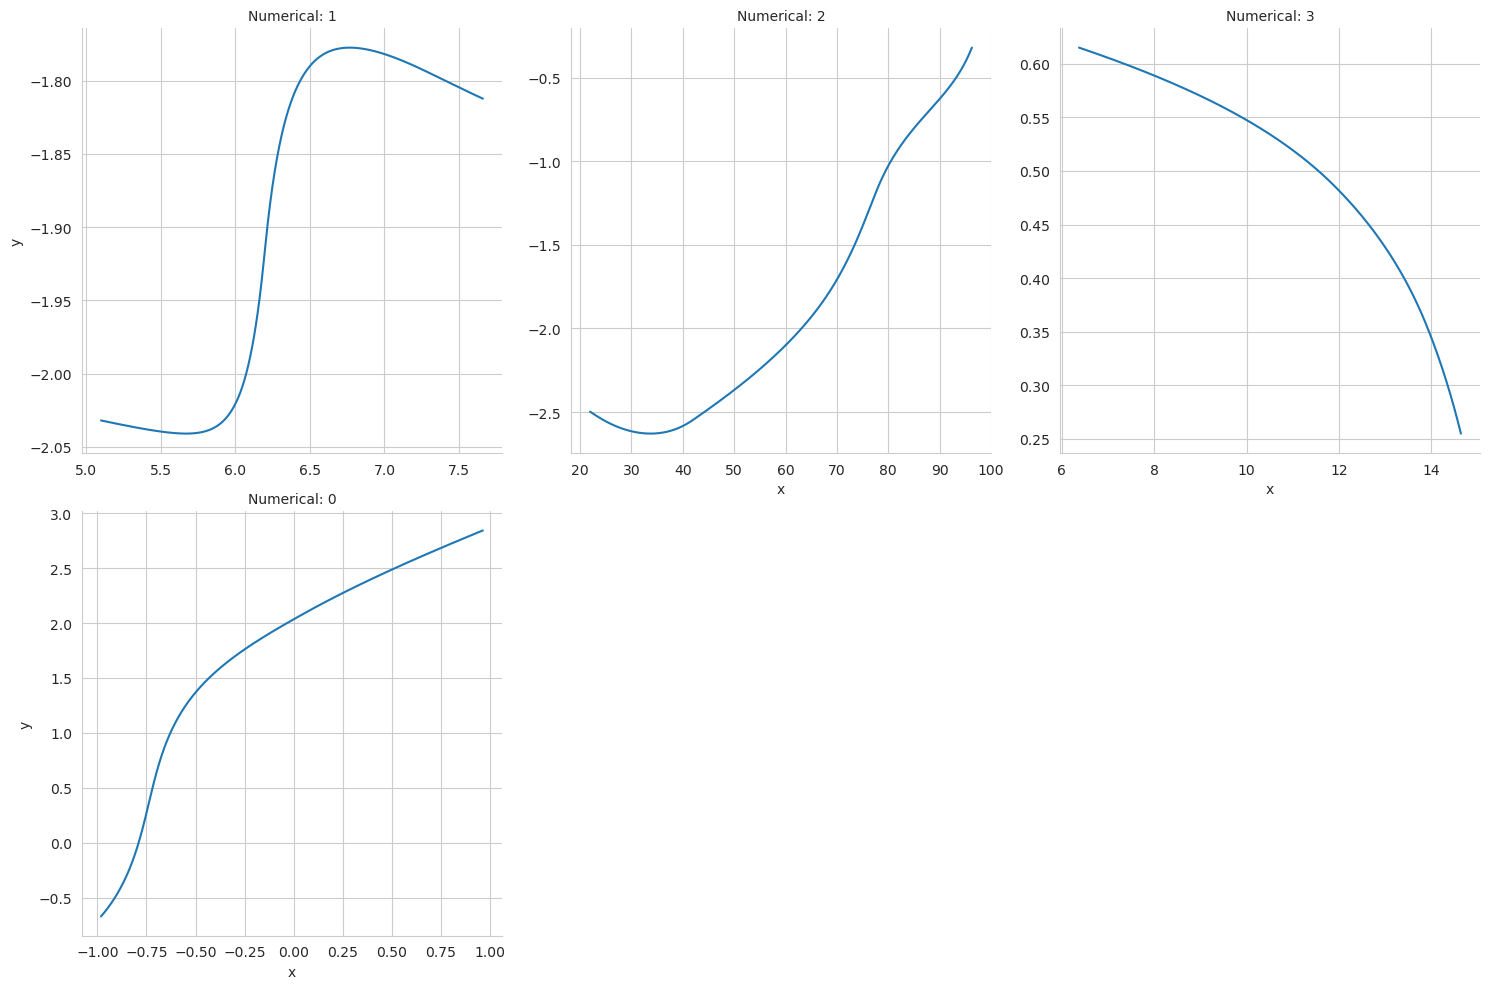

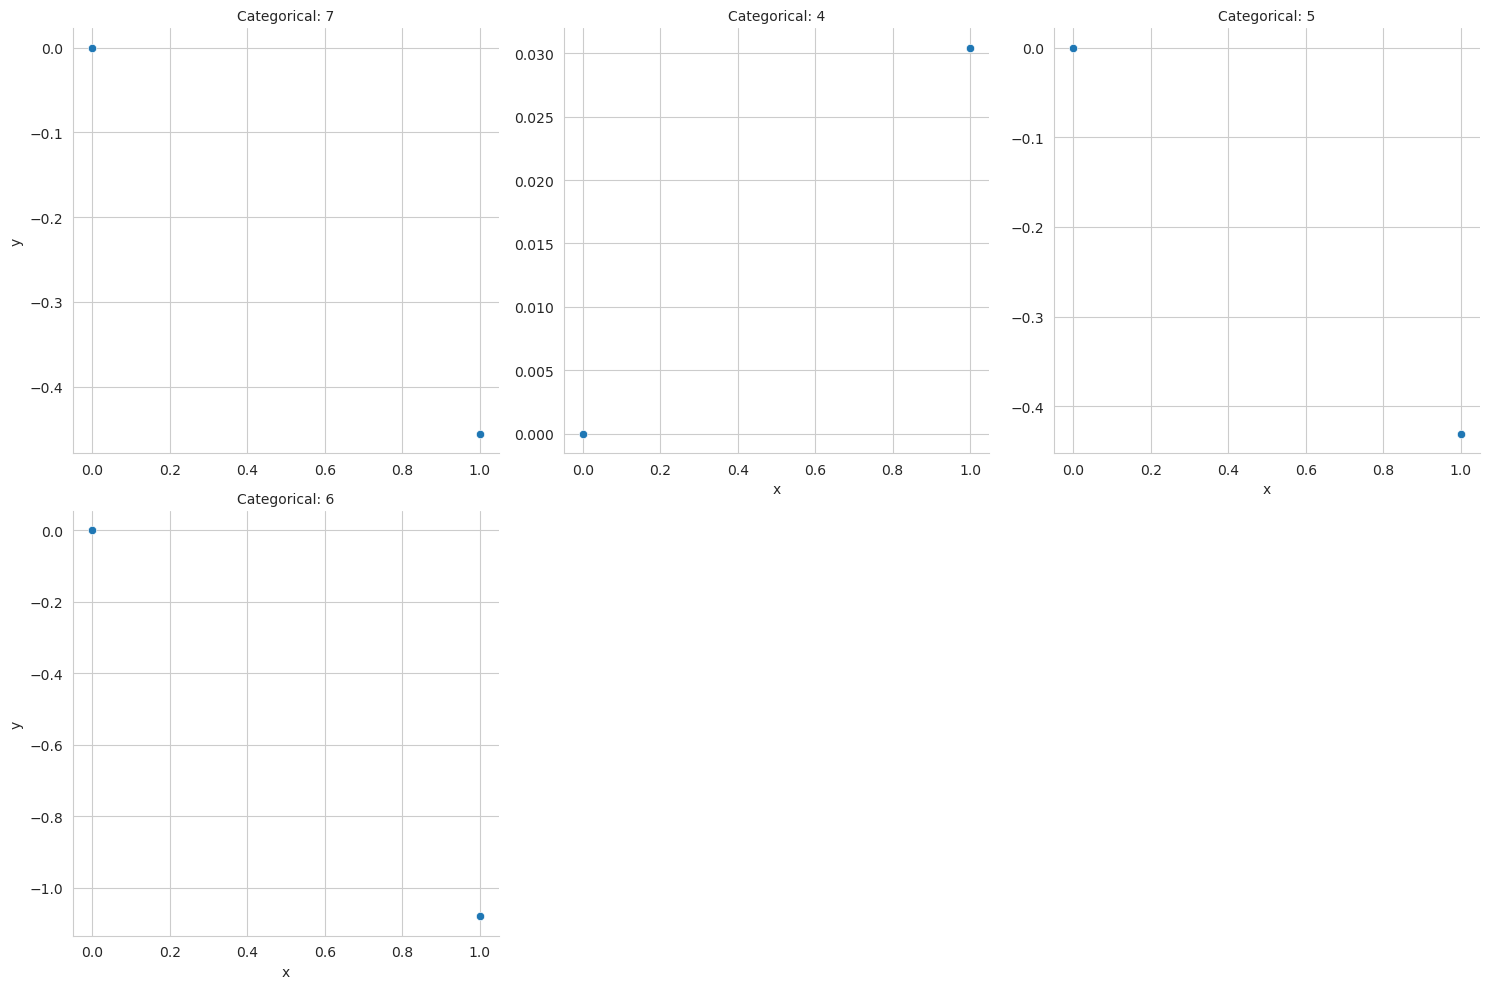

In [58]:
best_model._program.plot_shape_functions(dataset.numerical_ranges, dataset.categorical_values)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

{'mean_absolute_difference_binned': np.float64(0.09485916023165201),
 'mean_absolute_difference_smoothed': np.float64(0.4402413714547986),
 'median_absolute_difference_binned': np.float64(0.06787113910479481),
 'median_absolute_difference_smoothed': np.float64(0.4847321419154845)}

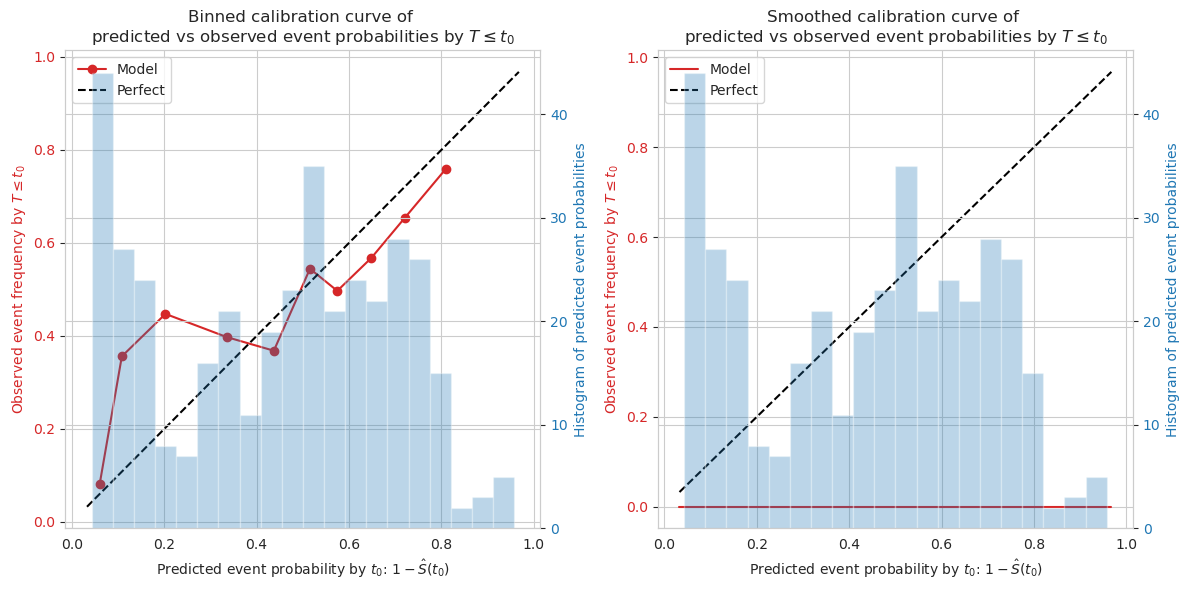

In [59]:
from survshares.hazard_model import HazardModel
hm = HazardModel(best_model, dataset.categorical_values).prepare_estimands(X_train, T_train, E_train)
hm.score(torch.Tensor(X_test), torch.Tensor(T_test), torch.Tensor(E_test), extended=False)
hm.plot_calibration(torch.Tensor(X_test), torch.Tensor(T_test), torch.Tensor(E_test), t0=np.unique(T_train)[len(T_train)//2])